In [81]:
import pathlib
import pickle

import scipy.cluster.hierarchy as spc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)

In [82]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/home/louis/Documents/6/ml/CSRoundPrediction/data


In [83]:
processed_file_path = DATA_DIR / 'processed' / 'csgo.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        categorical_variables,
    ) = pickle.load(file)

# Analyzing features individually

First it is fair to explain a little what we are analysing here. Counter-Strike is a computer game where two teams face each other, the terrorists (T), and the counter-terrorists (CT). Each of the team has 5 members, each being having 100 armor and being able to buy a variety of weapons, grenades and armor/helmet, by using money they get when the round ends. The rounds last 175 seconds each, and must end with either the Ts winning, by either killing all the CTs before the time ends or by planting a bomb and protecting it for the duration before it blows up. On the other hand, the CTs can win by either killing all the Ts, waiting for the time to run out or defusing the bomb after it is planted. The game ends when one of the teams hit 16, or if the game ties at 15-15, it'll begin a game of whoever wins 4 rounds first, if it ties at 3-3 again the same repeats, indefinetely (yes, it can last a very long time).

## Categorical features


Luckily for us, this dataset only has one categorical feature, the map where the match is being played. However, there is another categorical variable, that is the round winner, being defined as CT or T

In [84]:
def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values()
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()


               count unique         top   freq
map           122410      8  de_inferno  23811
round_winner  122410      2           T  62406


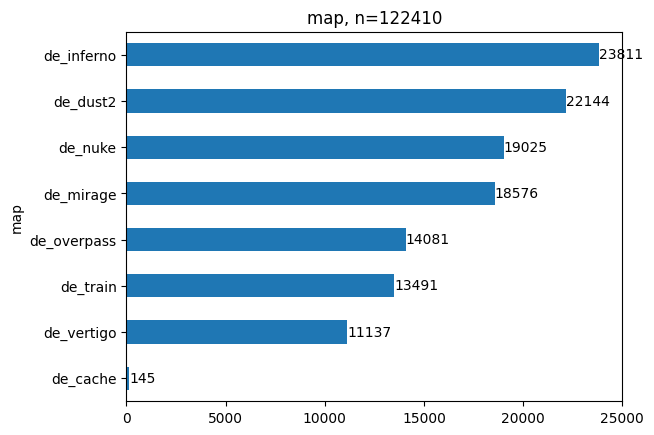

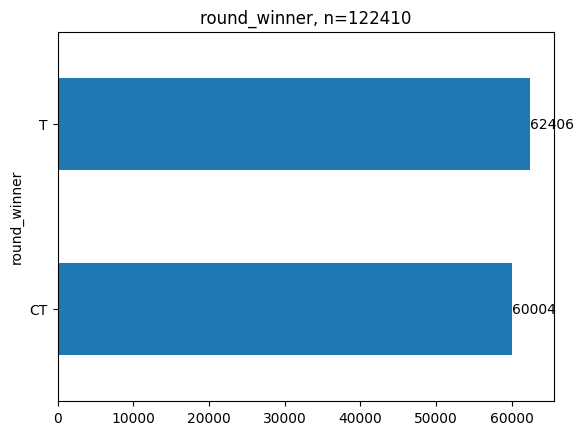

In [85]:
plot_categoricals(data, categorical_variables)

In [86]:
data['map'].value_counts()

map
de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: count, dtype: int64

In [87]:
pd.crosstab(data['map'], data['round_winner'], normalize='index')

round_winner,CT,T
map,,
de_cache,0.710345,0.289655
de_dust2,0.458725,0.541275
de_inferno,0.453992,0.546008
de_mirage,0.492248,0.507752
de_nuke,0.536873,0.463127
de_overpass,0.498970,0.501030
de_train,0.541843,0.458157
de_vertigo,0.470414,0.529586


### Transforming the round winner to a binary 

We can then transform the round winner to a binary value, where it will be 1 if the CTs won or 0 if the Ts won. 

In [88]:
# transformando as variaveis do round_winner em 0 e 1
data['round_winner'] = (data['round_winner'] == 'CT').astype(int)

We'll later on do a one-hot encoding for the map variable to deal with this problem as well

## Looking at numeric values

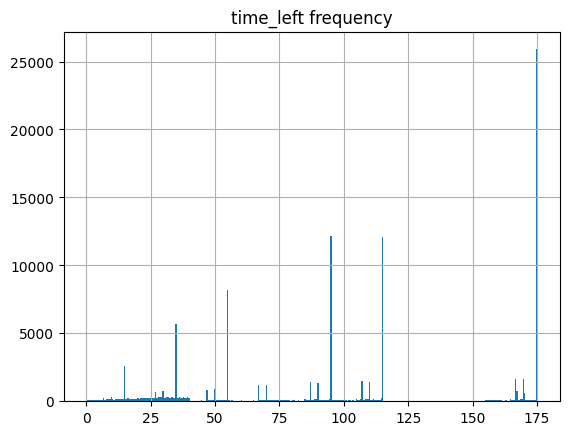

In [89]:
n = data.shape[0]
b = int(np.sqrt(n))
data['time_left'].hist(bins=b)
plt.title('time_left frequency')
plt.show()

First, we'll look at the time_left, since the data comes from random snapshots along the game, they are taken mostly in more or less the same time intervals, and getting less often, because the round can end before the time is up.

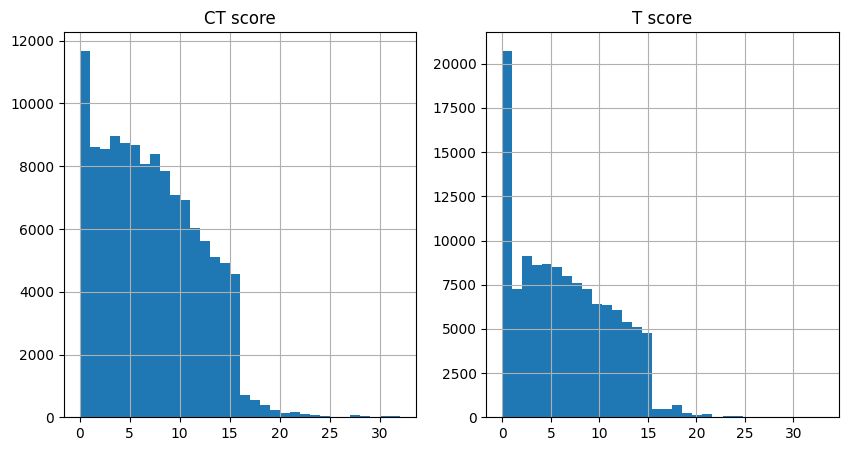

In [90]:
# plot ct_score and t_score on different subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data['ct_score'].hist(ax=axs[0], bins=32)
axs[0].set_title('CT score')
data['t_score'].hist(ax=axs[1], bins=32)
axs[1].set_title('T score')

plt.show()

Then, looking at the ct_score and the t_score, we can see the linearly going down until 16, which is the maximum score in a game of CS:GO, so this is expected. It can go a little more because of overtime, but that doesn't happen as often as going to 16.

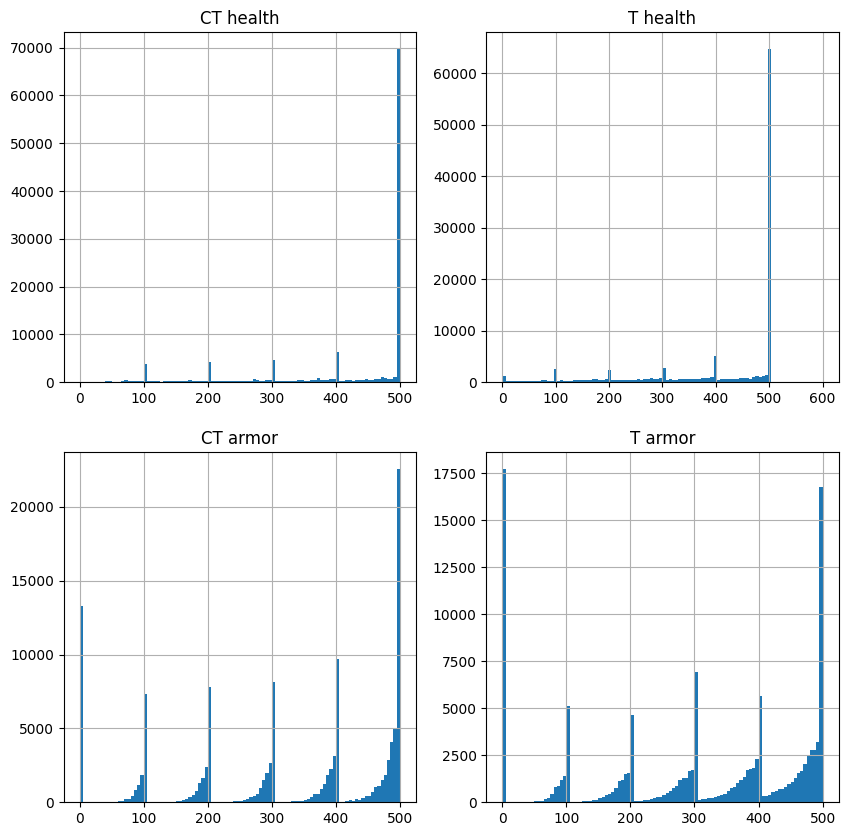

In [91]:
# plot ct_health, t_health, ct_armor, t_armor on different subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
data['ct_health'].hist(ax=axs[0, 0], bins=100)
axs[0, 0].set_title('CT health')

data['t_health'].hist(ax=axs[0, 1], bins=100)
axs[0, 1].set_title('T health')

data['ct_armor'].hist(ax=axs[1, 0], bins=100)
axs[1, 0].set_title('CT armor')

data['t_armor'].hist(ax=axs[1, 1], bins=100)
axs[1, 1].set_title('T armor')

plt.show()

After that, looking at the health and armor, we see that they jump from hundreds to hundreds. Since each of the 5 players can have at most 100 health and 100 armor, they tend to go down 100 by 100, since a player is more often killed between snapshots than just damaged.

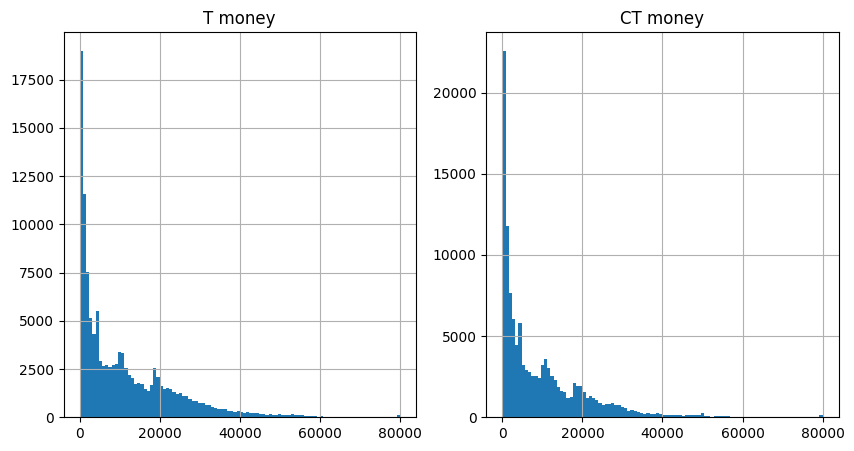

In [92]:
# Plot t_money and ct_money on different subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data['t_money'].hist(ax=axs[0], bins=100)
axs[0].set_title('T money')

data['ct_money'].hist(ax=axs[1], bins=100)
axs[1].set_title('CT money')

plt.show()

Then, we have the most interesting variable in my opinion, money. The money tends to stay mostyly between 0 and 1400, since 1400 is the minimum you can get in a round and 0 because players tend to spend all their money in the round.

The last curious variable to talk about are the weapons/grenades. Since there are over 80 of them we, of course, are not going to plot all of them, but the majority of them follow around the same pattern, tending to stay on 0, since there are a lot of weapons and players can only use one at a time. Then we can clearly see which wepons are the most popular, since they appear way more often than the others. The only exception for this are the t_weapon_glock and ct_weapon_usps, which are the starting weapons for each team, so they are the most common.

Since every player can choose to buy any weapon, we can see that some weapons that are not that important to the game, because they aren't used often. We can then remove these weapons from the dataset, since they are not relevant for the analysis. So we'll take a look at the weapons that appear less than 500 times in the dataset and remove them. 

In [93]:
for x in data:
    if 'weapon' in x or 'grenade' in x:
        total = 0
        for n in range(3):
            if n != 0:
                try:
                    total += data[x].value_counts()[n]
                except KeyError:
                    pass
        if total < 500:
            print(f'{x}: {total}')
            data = data.drop(columns=[x])

ct_weapon_bizon: 0
t_weapon_bizon: 10
ct_weapon_elite: 491
t_weapon_elite: 217
ct_weapon_g3sg1: 0
t_weapon_g3sg1: 63
ct_weapon_m249: 1
t_weapon_m249: 0
t_weapon_m4a1s: 328
t_weapon_mag7: 6
ct_weapon_mp5sd: 179
t_weapon_mp5sd: 324
ct_weapon_mp7: 245
t_weapon_mp7: 236
ct_weapon_negev: 0
t_weapon_negev: 1
ct_weapon_nova: 120
t_weapon_nova: 13
ct_weapon_p90: 20
t_weapon_p90: 19
ct_weapon_r8revolver: 0
t_weapon_r8revolver: 7
ct_weapon_sawedoff: 0
t_weapon_sawedoff: 17
ct_weapon_scar20: 88
t_weapon_scar20: 1
t_weapon_xm1014: 32


We can see that all of these weapons appear less than 500 times in the dataset, so we can remove them from the dataset. 

In [94]:
data.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750,0.490189
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162,0.499906
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000,1.000000


## Viewing the clean data

In [95]:
numerical_data = data.select_dtypes('number').drop(columns='round_winner').copy()
target = data['round_winner'].copy()

In [96]:
print(numerical_data.corrwith(target).filter(regex='^ct_').sort_values(ascending=False))

ct_armor                        0.336382
ct_helmets                      0.308255
ct_defuse_kits                  0.291557
ct_grenade_flashbang            0.253868
ct_players_alive                0.216798
ct_grenade_smokegrenade         0.209975
ct_weapon_awp                   0.198626
ct_health                       0.190662
ct_weapon_m4a4                  0.178008
ct_grenade_hegrenade            0.168781
ct_grenade_incendiarygrenade    0.168517
ct_weapon_ak47                  0.166855
ct_weapon_sg553                 0.163963
ct_weapon_usps                  0.152893
ct_money                        0.129326
ct_weapon_aug                   0.080578
ct_grenade_molotovgrenade       0.079758
ct_weapon_mp9                   0.064231
ct_score                        0.057304
ct_weapon_famas                 0.049922
ct_weapon_p250                  0.049614
ct_weapon_m4a1s                 0.047719
ct_weapon_tec9                  0.042672
ct_weapon_galilar               0.035162
ct_weapon_ump45 

Here we can take a look at the correlation between every counter terrorist variable and it's outcome on the round win for the defender team.

In [97]:
# Inverse because T is 0 
print(-numerical_data.corrwith(target).filter(regex='^t_').sort_values())

t_helmets                      0.297458
t_armor                        0.290753
t_weapon_ak47                  0.194147
t_grenade_flashbang            0.166839
t_weapon_sg553                 0.163709
t_weapon_awp                   0.149878
t_players_alive                0.142518
t_grenade_smokegrenade         0.140348
t_weapon_usps                  0.136694
t_grenade_molotovgrenade       0.116754
t_grenade_hegrenade            0.116336
t_money                        0.098362
t_health                       0.091361
t_weapon_m4a4                  0.088002
t_weapon_mac10                 0.087114
t_weapon_glock                 0.069004
t_weapon_ump45                 0.067326
t_weapon_galilar               0.062742
t_grenade_incendiarygrenade    0.050546
t_weapon_p250                  0.045456
t_weapon_fiveseven             0.037264
t_weapon_p2000                 0.036279
t_weapon_famas                 0.035858
t_weapon_aug                   0.031507
t_score                        0.026863


Here we are doing the same, but for the terrorist team.

With this data, we can see that weapons that are cheaper and used more frequently in rounds where the team is spending less money, tend to correlate with the team losing the round, probably because they have worse weapons. We can also see that the most important factor is helmets and armor, probably because they are the most essential thing to buy in every round, since they protect the player from being killed by a headshot and increase the player's overall survivability.

## Comparing features

In [98]:
corr = data.corr(numeric_only=True)
corrval = corr.values

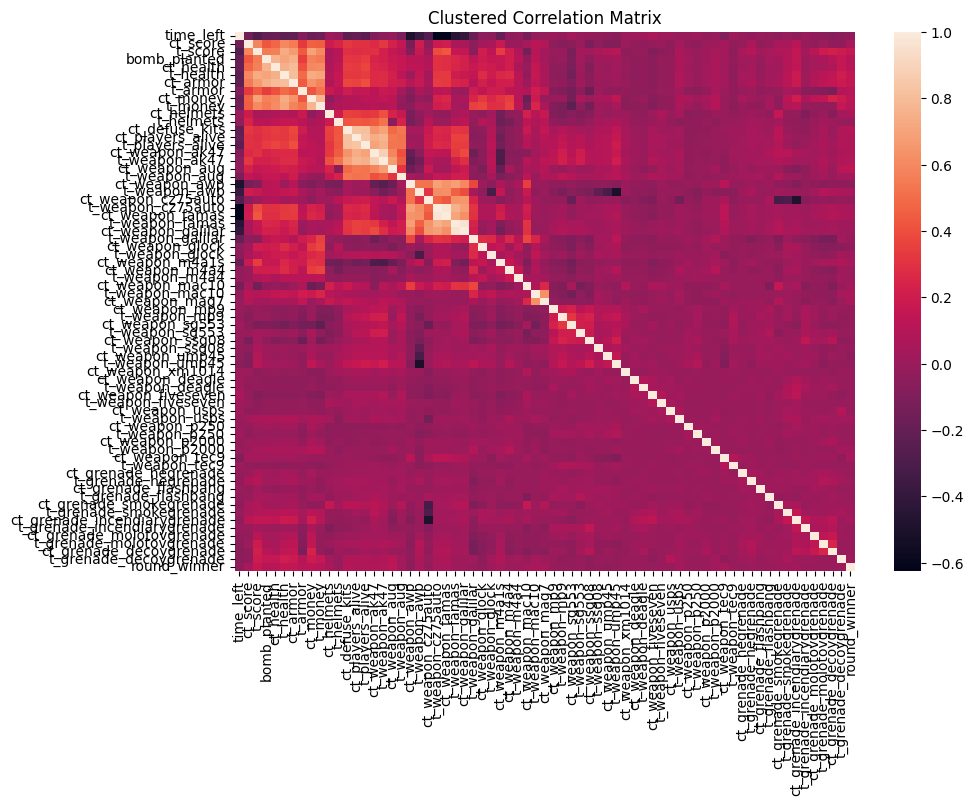

In [99]:
pdist = spc.distance.pdist(corrval)  # Compute the distance matrix
linkage = spc.linkage(pdist, method='complete')  # Perform hierarchical clustering

# Generate the indices that will reorder the matrix based on clustering
idx = spc.fcluster(linkage, 0.5 * pdist.max(), criterion='distance')
dendro = spc.dendrogram(linkage, no_plot=True)  # Get the order of clusters

# Reorder the correlation matrix according to the hierarchical clustering
corr_reordered = corrval[dendro['leaves'], :][:, dendro['leaves']]

# Plot the heatmap of the clustered correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(corr_reordered, xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Clustered Correlation Matrix")
plt.show()

This is a pretty tough one to just understand without reading a lot, but here we can see a lot of similarities to the data seen above with correlations, but we can also see that there isn't one clear path to victory, just slight things that might improve your odds.

## Encoding Categorical Variable

In [117]:
model_data = data.copy()

original_data = model_data['map']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data

aux_dataframe.head()

,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [118]:
model_data = pd.concat([model_data, encoded_data], axis=1)
print(model_data['map'].value_counts())

map
de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: count, dtype: int64


In [119]:
model_data = model_data.drop(columns=['map'])

In [120]:
model_data.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
0,175.00,0.0,0.0,False,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,0.0,1,True,False,False,False,False,False,False
1,156.03,0.0,0.0,False,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,0.0,1,True,False,False,False,False,False,False
2,96.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,1,True,False,False,False,False,False,False
3,76.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,1,True,False,False,False,False,False,False
4,174.97,1.0,0.0,False,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,0.0,1,True,False,False,False,False,False,False


In [121]:
data.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [122]:
print(data.shape)
print(model_data.shape)

(122410, 70)
(122410, 76)


## Saving cleaned data

In [123]:
clean_data_path = DATA_DIR / 'processed' / 'csgo_clean.pkl'

In [124]:
with open(clean_data_path, 'wb') as file:
    pickle.dump(model_data, file)